
# Polynomial and Spline interpolation

This example demonstrates how to approximate a function with polynomials up to
degree ``degree`` by using ridge regression. We show two different ways given
``n_samples`` of 1d points ``x_i``:

- :class:`~sklearn.preprocessing.PolynomialFeatures` generates all monomials
  up to ``degree``. This gives us the so called Vandermonde matrix with
  ``n_samples`` rows and ``degree + 1`` columns::

    [[1, x_0, x_0 ** 2, x_0 ** 3, ..., x_0 ** degree],
     [1, x_1, x_1 ** 2, x_1 ** 3, ..., x_1 ** degree],
     ...]

  Intuitively, this matrix can be interpreted as a matrix of pseudo features
  (the points raised to some power). The matrix is akin to (but different from)
  the matrix induced by a polynomial kernel.

- :class:`~sklearn.preprocessing.SplineTransformer` generates B-spline basis
  functions. A basis function of a B-spline is a piece-wise polynomial function
  of degree ``degree`` that is non-zero only between ``degree+1`` consecutive
  knots. Given ``n_knots`` number of knots, this results in matrix of
  ``n_samples`` rows and ``n_knots + degree - 1`` columns::

    [[basis_1(x_0), basis_2(x_0), ...],
     [basis_1(x_1), basis_2(x_1), ...],
     ...]

This example shows that these two transformers are well suited to model
non-linear effects with a linear model, using a pipeline to add non-linear
features. Kernel methods extend this idea and can induce very high (even
infinite) dimensional feature spaces.


In [1]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

We start by defining a function that we intend to approximate and prepare
plotting it.



In [2]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

To make it interesting, we only give a small subset of points to train on.



In [21]:
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=50, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

Now we are ready to create polynomial features and splines, fit on the
training points and show how well they interpolate.



### SplineTransformer in Scikit-Learn

#### Concept

`SplineTransformer` is a preprocessing class in Scikit-Learn that generates spline basis functions for features. Splines are piecewise polynomial functions that are used to model complex, nonlinear relationships. This transformer allows you to capture such nonlinearities in the data, making it a powerful tool for feature engineering in regression and other predictive modeling tasks.

#### Mathematical Background

Splines are defined by a set of polynomial segments connected at points called knots. The segments are defined such that they are smooth at the knots, meaning they have continuous derivatives up to a specified order.

For a given input feature $\ x $, a spline basis function $\ B_j(x) $ can be represented as:

$\
B_j(x) = 
\begin{cases} 
p_0(x) & \text{if } x \leq \xi_1 \\
p_1(x) & \text{if } \xi_1 < x \leq \xi_2 \\
\vdots \\
p_k(x) & \text{if } x > \xi_{k-1} \\
\end{cases}
$

where $\ p_i(x) $ are polynomial functions, and $\ \xi_i $ are the knots.

The main types of spline functions are:

1. **B-Splines (Basis Splines)**:
   - Defined by a set of basis functions $\ B_{i, d}(x) $ where $\ d $ is the degree of the polynomial.
   - B-Splines ensure smoothness at the knots up to the $\ (d-1) $-th derivative.

2. **Natural Cubic Splines**:
   - Cubic splines that are linear beyond the boundary knots, ensuring natural boundary conditions.

#### SplineTransformer in Scikit-Learn

`SplineTransformer` generates a matrix of spline basis functions for each input feature. This transformation is particularly useful when you want to introduce nonlinearity into a linear model.

##### Key Parameters

- **n_knots**: The number of knots to use for the spline. Default is 5.
- **degree**: The degree of the spline. Default is 3 (cubic splines).
- **knots**: The positions of the knots. Default is "uniform", which places knots uniformly within the feature range. Other options include "quantile".
- **extrapolation**: Specifies the type of extrapolation for values outside the training data range. Options are "constant", "linear", "continue", and "periodic".
- **include_bias**: If True, includes a bias column in the output. Default is True.


**Transform Process**:
When you fit and transform data using `SplineTransformer`, the transformer computes the spline basis functions for each feature and creates a new feature space where each original feature is represented by multiple spline basis functions.

#### Attributes

- **bsplines_**: List of BSplines objects, one for each feature.
- **n_features_in_**: The total number of input features.
- **feature_names_in_**: Names of features seen during `fit`. Defined only when `X` has feature names that are all strings.
- **n_features_out_**: The total number of output features, computed as `n_features * n_splines`.

#### Example Usage


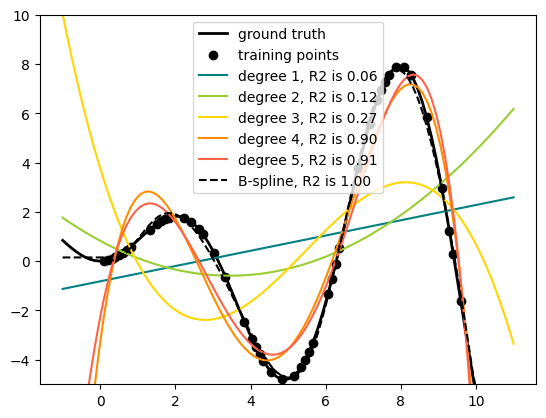

In [51]:
# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [1,2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}, R2 is { model.score(X_train,y_train):.2f}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=6, degree=3,knots='quantile'), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label=f"B-spline, R2 is { model.score(X_train,y_train):.2f}",ls = 'dashed')
ax.legend(loc="upper center")
ax.set_ylim(-5, 10)
plt.show()

This shows nicely that higher degree polynomials can fit the data better. But
at the same time, too high powers can show unwanted oscillatory behaviour
and are particularly dangerous for extrapolation beyond the range of fitted
data. This is an advantage of B-splines. They usually fit the data as well as
polynomials and show very nice and smooth behaviour. They have also good
options to control the extrapolation, which defaults to continue with a
constant. Note that most often, you would rather increase the number of knots
but keep ``degree=3``.

In order to give more insights into the generated feature bases, we plot all
columns of both transformers separately.



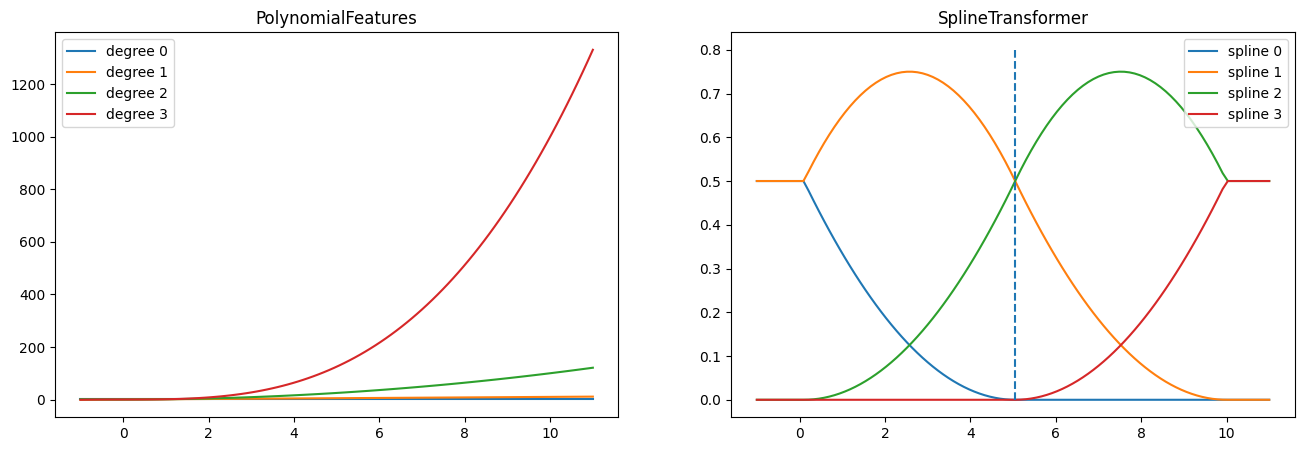

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
pft = PolynomialFeatures(degree=3).fit(X_train)
axes[0].plot(x_plot, pft.transform(X_plot))
axes[0].legend(axes[0].lines, [f"degree {n}" for n in range(4)])
axes[0].set_title("PolynomialFeatures")

splt = SplineTransformer(n_knots=3, degree=2).fit(X_train)
axes[1].plot(x_plot, splt.transform(X_plot))
axes[1].legend(axes[1].lines, [f"spline {n}" for n in range(6)])
axes[1].set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes[1].vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

n_splines = n_knots + n_degree - 1

n_basis function = n_features * n_splines

### Explanation of Output

- Each row in the transformed array represents the spline basis functions evaluated at the corresponding input value.
- Each column corresponds to a different spline basis function.
- For example, the first row `[0.5, 0.5, 0.0, 0.0]` represents the spline basis functions evaluated at \( x=0 \).

### Differences from Polynomial Features

- **Local vs Global**: Polynomial features create global polynomials over the entire range of the input data, leading to high-degree polynomials that can oscillate and exhibit poor generalization (Runge's phenomenon). Splines, on the other hand, are piecewise polynomials defined locally between knots, which results in more stable and flexible models.
- **Smoothness**: Splines are designed to be smooth at the knots, ensuring continuity of the function and its derivatives up to a certain order. Polynomial features do not inherently provide this smoothness.
- **Flexibility**: Splines offer more flexibility in modeling complex, nonlinear relationships by adjusting the number and placement of knots. Polynomial features, especially high-degree ones, can become unstable and overfit the data.
- **Basis Functions**: `SplineTransformer` generates basis functions specific to the spline type and knots, whereas polynomial features generate standard polynomial terms (e.g., \( x, x^2, x^3, \ldots \)).

### Summary

In summary, `SplineTransformer` provides a powerful tool for capturing nonlinear relationships in the data using spline basis functions. It offers advantages in terms of flexibility, smoothness, and stability compared to traditional polynomial features.


In the left plot, we recognize the lines corresponding to simple monomials
from ``x**0`` to ``x**3``. In the right figure, we see the six B-spline
basis functions of ``degree=3`` and also the four knot positions that were
chosen during ``fit``. Note that there are ``degree`` number of additional
knots each to the left and to the right of the fitted interval. These are
there for technical reasons, so we refrain from showing them. Every basis
function has local support and is continued as a constant beyond the fitted
range. This extrapolating behaviour could be changed by the argument
``extrapolation``.



## Periodic Splines
In the previous example we saw the limitations of polynomials and splines for
extrapolation beyond the range of the training observations. In some
settings, e.g. with seasonal effects, we expect a periodic continuation of
the underlying signal. Such effects can be modelled using periodic splines,
which have equal function value and equal derivatives at the first and last
knot. In the following case we show how periodic splines provide a better fit
both within and outside of the range of training data given the additional
information of periodicity. The splines period is the distance between
the first and last knot, which we specify manually.

Periodic splines can also be useful for naturally periodic features (such as
day of the year), as the smoothness at the boundary knots prevents a jump in
the transformed values (e.g. from Dec 31st to Jan 1st). For such naturally
periodic features or more generally features where the period is known, it is
advised to explicitly pass this information to the `SplineTransformer` by
setting the knots manually.



C:\Users\marti\AppData\Local\Temp\ipykernel_22676\63528436.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


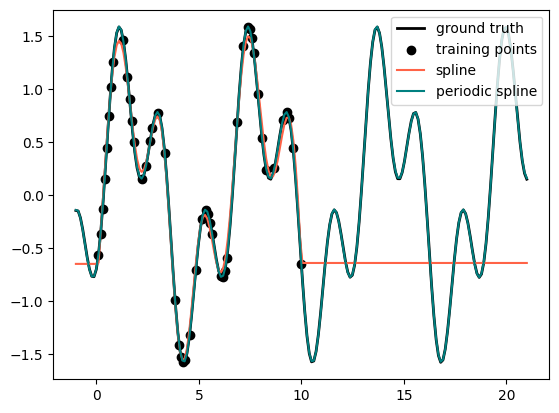

In [58]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)


y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=8, n_knots=12), "spline"),
    (
        SplineTransformer(
            degree=6,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

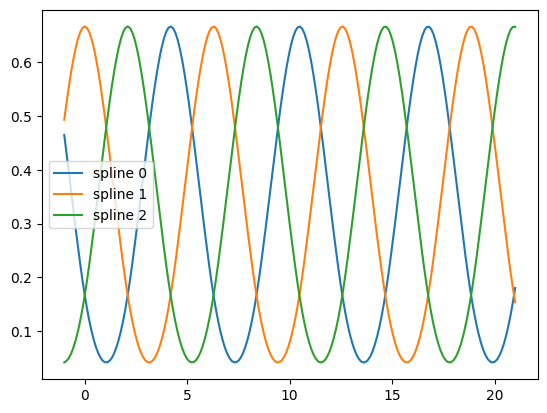

In [7]:
fig, ax = plt.subplots()
knots = np.linspace(0, 2 * np.pi, 4)
splt = SplineTransformer(knots=knots[:, None], degree=3, extrapolation="periodic").fit(
    X_train
)
ax.plot(x_plot_ext, splt.transform(X_plot_ext))
ax.legend(ax.lines, [f"spline {n}" for n in range(3)])
plt.show()